In [36]:
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

np.random.seed(3123)

In [16]:
data=pd.read_csv('mimic_train.csv')
mimic_diagnoses_df = pd.read_csv('MIMIC_diagnoses.csv')
test=pd.read_csv('mimic_X_test.csv')

Our first task is to join the main training dataset with the diagnoses file. Prior to that, we make sure both files have the same column names and then perform the joining function.  

In [17]:
data=data.drop(columns='ICD9_diagnosis')
#Rename some columns on the diagnoses file to match the main dataset
mimic_diagnoses_df.rename(columns={'ICD9_CODE':'ICD9_diagnosis', 'SUBJECT_ID':'subject_id','HADM_ID':'hadm_id' }, inplace=True)

In [18]:
data = data.merge(mimic_diagnoses_df[['subject_id', 'hadm_id', 'SEQ_NUM', 'ICD9_diagnosis']], on=['subject_id', 'hadm_id'], how='left')

## DATA INSPECTION

### AGE VARIABLE

In our dataset, we have a column called `DOB` (Date of Birth), which contains the birth dates of the patients. Our objective is to derive an **age group** variable based on the patient's age, which will be used to understand the relationship between age and other variables in predicting the target (e.g., mortality rate).

To do so, we will use the column 'ADMITTIME' (Admission time) and will substract 'DOB' (Date of Birth) to it in order to achieve the Age. 

In [19]:
# Ensure DOB is a string
data['DOB'] = data['DOB'].astype(str)
data['ADMITTIME']=data['ADMITTIME'].astype(str)
test['DOB'] = test['DOB'].astype(str)
test['ADMITTIME']=test['ADMITTIME'].astype(str)

# Extract the first four characters for the year
data['DOB'] = data['DOB'].str[:4].astype(int)
data['ADMITTIME'] = data['ADMITTIME'].str[:4].astype(int)
test['DOB'] = test['DOB'].str[:4].astype(int)
test['ADMITTIME'] = test['ADMITTIME'].str[:4].astype(int)

#Calculate the Age
data['Age']=data['ADMITTIME']-data['DOB']
test['Age']=test['ADMITTIME']-test['DOB']

Now we plot the histogram to visualize the Age distribution

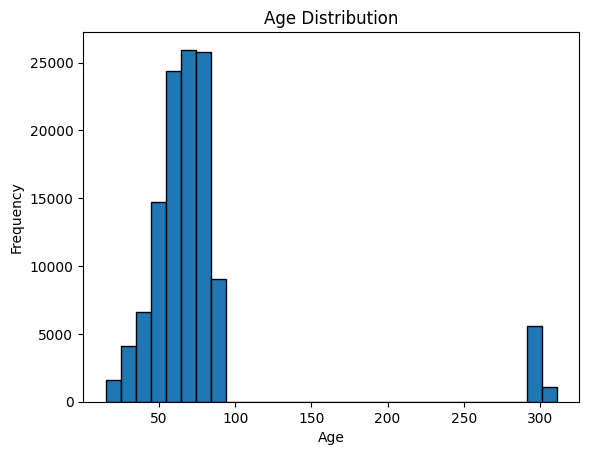

In [20]:
# Plot the histogram
plt.hist(data['Age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

By cheking the MIMIC website, we can see that patients over 89 are given an age of 300. Taking this into consideration, the next step is to change those aged over 300, to age 90

In [21]:
data['Age'] = data['Age'].apply(lambda x: 90 if x > 250 else x)
test['Age'] = test['Age'].apply(lambda x: 90 if x > 250 else x)

In [ ]:
# Define the age bins and labels
age_bins = [0, 20, 40, 60, 80, float('inf')]  # Create 5 bins
age_labels = ['0-19', '20-39', '40-59', '60-79', '80+']  # Labels for the bins

# Create a new column for the age category
data['Age_Category'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)
test['Age_Category'] = pd.cut(test['Age'], bins=age_bins, labels=age_labels, right=False)

# One-hot encode the Age_Category column to create dummy variables
data = pd.get_dummies(data, columns=['Age_Category'], prefix='Age', drop_first=False)
test = pd.get_dummies(test, columns=['Age_Category'], prefix='Age', drop_first=False)

We start by checking out what variables each patient has, in order to find any non-essential columns that will not add any value to our model.  

In [9]:
data.columns

Index(['Unnamed: 0', 'HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id',
       'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB', 'DOD',
       'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'FIRST_CAREUNIT', 'LOS', 'SEQ_NUM', 'ICD9_diagnosis', 'Age', 'Age_0-19',
       'Age_20-39', 'Age_40-59', 'Age_60-79', 'Age_80+'],
      dtype='object')

Now we drop columns with categorical data that we predict will be of no use (e.g., marital_status, religion, etc.) and certain date columns that don't seem to have apparent use.

Although a simple logistic regression based on the existence of a deathtime value and the hospital_expire_flag would yield 100% accuracy, we will drop the columns ['dod', 'dischtime', 'deathtime', 'los'] to maintain the focus on the exercise's purpose.

In [ ]:
data.drop(columns=['DOD', 'Age',
        'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'LOS', 'ADMITTIME', 'DOB', 'SEQ_NUM'],inplace=True)
test.drop(columns=['DOD', 'Age',
        'DISCHTIME', 'DEATHTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'LOS', 'ADMITTIME', 'DOB'],inplace=True)

After checking the data type of each column  ( to see if we should drop more columns, or dummify some others) with data.dtype, we  decide to convert gender and will further explore first_careunit to check if we could also use it.

In [24]:
data['FIRST_CAREUNIT'].nunique()

5

Given that there are only 5 different values in the column, we can easily dummify it to gain some additional information for our regression. Because we will run a KNN later, it is best to dummify categorical values rather than encoding them with single integer values, as we know that KNN relies on distance and could misinterpret 1 closer to 2 than to 5.

In [25]:
# Convert the GENDER column to dummy variables
data_gender = pd.get_dummies(data, columns=['GENDER'], prefix='Gender')
test_gender = pd.get_dummies(test, columns=['GENDER'], prefix='Gender')
# Convert the FIRAST_CAREUNIT column to dummy variables
data_with_dummies = pd.get_dummies(data_gender, columns=['FIRST_CAREUNIT'], prefix='CareUnit')
test_with_dummies = pd.get_dummies(test_gender, columns=['FIRST_CAREUNIT'], prefix='CareUnit')

We must now deal with our most important variable for each patient, its diagnosis. The best approach considered would be to dummify the variable ICD9_diagnosis, but for large datasets with too many different ICD9 values, this would dangerously increase computational time, so we want to avoid it. 

Instead, we target encode ICD9_diagnosis, replacing each unique category with the average target variable for that diagnosis, which will be the mortality rate. For that, we must group the categories and calculate their mortality rates, to later substitute the icd9_diagnosis category by its mortality rate.  

In [26]:
# Step 1: Calculate mortality rates for all ICD9 codes
icd9_target_encoding = data_with_dummies.groupby('ICD9_diagnosis')['HOSPITAL_EXPIRE_FLAG'].mean()

# Step 2: Map the mortality rates to mimic_diagnoses
data_with_dummies['mortality_rate'] = data_with_dummies['ICD9_diagnosis'].map(icd9_target_encoding)
data_with_dummies['mortality_rate'].fillna(0, inplace=True)

# Step 3: Aggregate by hadm_id to find the max mortality rate for each hadm_id
max_mortality_rates = data_with_dummies.groupby('hadm_id')['mortality_rate'].max()

# Step 4: Map the max mortality rate back to data_with_dummies using hadm_id
data_with_dummies['mortality_rate'] = data_with_dummies['hadm_id'].map(max_mortality_rates)



/tmp/ipykernel_3509/2417969153.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_with_dummies['mortality_rate'].fillna(0, inplace=True)


### FREQUENCY ENCODING EACH ICD9_DIAGNOSIS

In [ ]:
# Step 1: Calculate the frequency of each ICD9_CODE
icd9_frequency_encoding = data_with_dummies['ICD9_diagnosis'].value_counts(normalize=True)

# Step 2: Map the frequencies to mimic_diagnoses
data_with_dummies['ICD9_frequency'] = data_with_dummies['ICD9_diagnosis'].map(icd9_frequency_encoding)
# Step 5: Drop the original ICD9_diagnosis column if no longer needed
data_with_dummies.drop(columns=['ICD9_diagnosis'], inplace=True, errors='ignore')
test_with_dummies.drop(columns=['ICD9_diagnosis'], inplace=True, errors='ignore')

In [30]:
data_with_dummies.head(10)

,Unnamed: 0,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,...,Age_80+,Gender_F,Gender_M,CareUnit_CCU,CareUnit_CSRU,CareUnit_MICU,CareUnit_SICU,CareUnit_TSICU,mortality_rate,ICD9_frequency
0,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.001716
1,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.000858
2,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.002944
3,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.002641
4,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.002431
5,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.000496
6,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.017370
7,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.003281
8,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.002187
9,6733,0,77502,151200,299699,89.0,116.0,102.677419,97.0,150.0,...,False,True,False,False,False,True,False,False,0.254902,0.012222


### Steps followed during target encoding
1. *Group by ICD9_diagnosis*: We first group the data by the ICD9_diagnosis column, which contains the diagnosis codes, and calculate the mean of HOSPITAL_EXPIRE_FLAG for each group. This gives us the mortality rate (the probability of death) for each unique diagnosis code.

2. *Map the encoding back to the dataset*: We then map these calculated mortality rates back to the ICD9_diagnosis column in the original dataframe, creating a new column ICD9_mortality_rate.

Finally, we drop the original ICD9_diagnosis, which will be of no more use.



To avoid running into Nans when applying the target encoding technique into the testing dataset, we calculate the overall mean mortality rate (for the entire training dataset) and apply it to any unrecognised icd9 diagnoses from the testing dataset. 

## MISSING DATA.

In [35]:
print(data_with_dummies.shape)
print(data_with_dummies.iloc[:,:30].isnull().sum()
      )

(118884, 43)
Unnamed: 0                  0
HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min           10538
HeartRate_Max           10538
HeartRate_Mean          10538
SysBP_Min               10646
SysBP_Max               10646
SysBP_Mean              10646
DiasBP_Min              10646
DiasBP_Max              10646
DiasBP_Mean             10646
MeanBP_Min              10542
MeanBP_Max              10542
MeanBP_Mean             10542
RespRate_Min            10556
RespRate_Max            10556
RespRate_Mean           10556
TempC_Min               12429
TempC_Max               12429
TempC_Mean              12429
SpO2_Min                10649
SpO2_Max                10649
SpO2_Mean               10649
Glucose_Min              1029
Glucose_Max              1029
Glucose_Mean             1029
Age_0-19                    0
dtype: int64


Seeing that no column has over 15% of Nan's, we will not drop any of them, but rather fill the gaps with different methods.

### METHOD 1

For Glucose levels, because there are very few missing rows, we will simply fill them with the mean of the other values, which will not significantly deviate  the variance

In [38]:
from sklearn.impute import SimpleImputer
glucose_columns = ['Glucose_Min', 'Glucose_Max', 'Glucose_Mean']

# Initialize the imputer for mean imputation
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer on the glucose columns and transform them
data_glucose_imputed = imp_mean.fit_transform(data_with_dummies[glucose_columns])
test_glucose_imputed = imp_mean.fit_transform(test_with_dummies[glucose_columns])

# Convert the result back to a DataFrame and assign it back to the original columns
data_with_dummies[glucose_columns] = pd.DataFrame(data_glucose_imputed, columns=glucose_columns)
test_with_dummies[glucose_columns] = pd.DataFrame(test_glucose_imputed, columns=glucose_columns)


To fill the rest of the missing data, the best approach we find is to run a linear regression or a knn taking the age and gender into account, which we consider will affect most for remaining variables such as heart rate, respiration rate, etc.

### METHOD 2

A linear regression imputation taking all other columns into account would be impossible because most of the columns have missing values themselves, which makes it impossible to, for instance, impute heart rate regressing it on other variables such as respiration rate.

Therefore, we will run a KNN, standardizing variable 'Age' (TAKES AROUND 20 MINS TO RUN)

In [37]:
# Step 1: Identify numerical columns
numerical_columns = data_with_dummies.select_dtypes(include=['number']).columns

# Step 2: Initialize the median imputer
median_imputer = SimpleImputer(strategy='median')

# Step 3: Apply the imputer only to numerical columns
data_with_dummies[numerical_columns] = median_imputer.fit_transform(data_with_dummies[numerical_columns])

In [40]:
print(data_with_dummies.shape)
data_with_dummies.iloc[:,:38].isnull().sum()

(118884, 43)


Unnamed: 0              0
HOSPITAL_EXPIRE_FLAG    0
subject_id              0
hadm_id                 0
icustay_id              0
HeartRate_Min           0
HeartRate_Max           0
HeartRate_Mean          0
SysBP_Min               0
SysBP_Max               0
SysBP_Mean              0
DiasBP_Min              0
DiasBP_Max              0
DiasBP_Mean             0
MeanBP_Min              0
MeanBP_Max              0
MeanBP_Mean             0
RespRate_Min            0
RespRate_Max            0
RespRate_Mean           0
TempC_Min               0
TempC_Max               0
TempC_Mean              0
SpO2_Min                0
SpO2_Max                0
SpO2_Mean               0
Glucose_Min             0
Glucose_Max             0
Glucose_Mean            0
Age_0-19                0
Age_20-39               0
Age_40-59               0
Age_60-79               0
Age_80+                 0
Gender_F                0
Gender_M                0
CareUnit_CCU            0
CareUnit_CSRU           0
dtype: int64

Once all data is ready to be fitted into a model, we first separate the training data into X and Y

In [41]:
# Split data_no_missing into features and target
X_train = data_with_dummies.drop(columns=['HOSPITAL_EXPIRE_FLAG'])
y_train = data_with_dummies['HOSPITAL_EXPIRE_FLAG']

In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

Now almost everything is set to fit our model, which will be a KNN. We want to experiment with the number of neighbors to take into account in our KNN model (optimal_k), and the different weights we will apply to our features. 

For computational purposes, we firstly fix our weights (with values we guessed) and find optimal_k. Once we have found it, we proceed to experiment with different weights to check for the best results. 

The knn runs with the 'Brute force' algorithm, as after trying the 'Ball tree' to reduce the computation time, no results seemed to be achieved. 

For a series of k values presented below, we run a cross validation with 5 folds and store the score in a list, from which we later plot the results and find the best k. 

Optimal number of neighbors: 120


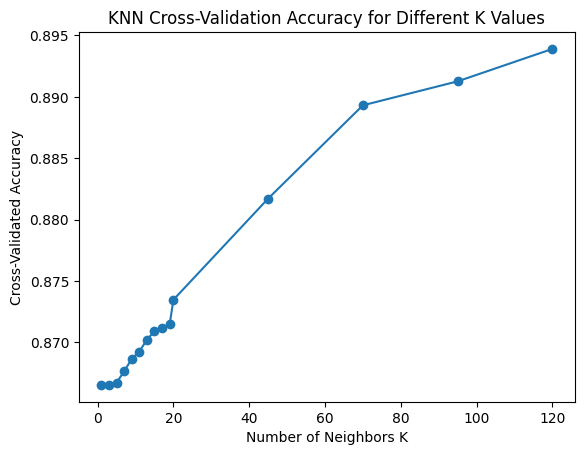

In [45]:
# Scale the data to ensure comparable feature scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Locate the column indexes for each variable
icd9_index = X_train.columns.get_loc('mortality_rate')
gender_m_index = X_train.columns.get_loc('Gender_M')
gender_f_index = X_train.columns.get_loc('Gender_F')

# Apply the weights by multiplying the corresponding columns
X_train_scaled[:, icd9_index] *= 7  # Increase weight of ICD9_mortality_rate by a factor of 7
X_train_scaled[:, gender_m_index] *= 2  # Increase weight of Gender by a factor of 2
X_train_scaled[:, gender_f_index] *= 2


# Range of K values to test
k_values = list(range(1, 20, 2)) + list(range(20,126, 25)) 

# List to store cross-validation scores for each K
cv_scores = []

# Loop through each K value
for k in k_values:
    # Define the KNN model with the current K value
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Perform cross-validation and calculate the mean accuracy
    scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determine the optimal K (the one with the highest mean cross-validation accuracy)
optimal_k = k_values[np.argmax(cv_scores)]
print(f"Optimal number of neighbors: {optimal_k}")

# Plotting the results
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Cross-Validation Accuracy for Different K Values')
plt.show()

After having found an aproximate optimium k, we now search for the optimum weights. For that, we will try three different values for our icd9_moratlity_rate, gender and age. It is believed that the most important feature is the mortality rate of the icd9 diagnosis a patient presents, so that will be our most important factor. Age and gender are also believed to be more important than other factors, so will have some weight as well. 

In [ ]:
# Define ranges for weights to test
icd9_weights = [7, 10, 15]  # Sample weights for 'ICD9_mortality_rate'
gender_weights = [1, 2, 3]  # Sample weights for 'Gender'

# Store results
weight_results = []

# Loop through each combination of weights
for icd9_w in icd9_weights:
    for gender_w in gender_weights:    
        # Scale data with specified weights
        X_train_scaled = scaler.fit_transform(X_train) #normalize all of the data
        X_train_scaled[:, icd9_index] *= icd9_w
        X_train_scaled[:, gender_m_index] *= gender_w
        X_train_scaled[:, gender_f_index] *= gender_w            

        # Run KNN with optimal K=95
        knn_model = KNeighborsClassifier(n_neighbors=120)
        auc_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        mean_auc = auc_scores.mean()

        # Store results for each weight combination
        weight_results.append({
            'ICD9_mortality_rate_weight': icd9_w,
            'Gender_weight': gender_w,                
            'AUC_score': mean_auc
        })

# Convert results to a DataFrame for easier comparison
import pandas as pd
results_df = pd.DataFrame(weight_results)

# Sort and display top AUC scores with their respective weights
top_results = results_df.sort_values(by='AUC_score', ascending=False).head(10)
print(top_results)


    ICD9_mortality_rate_weight  Gender_weight  Age_weight  AUC_score
9                           10              1           2   0.858206
10                          10              1           4   0.858206
11                          10              1           6   0.858206
22                          15              2           4   0.857126
21                          15              2           2   0.857126
23                          15              2           6   0.857126
24                          15              3           2   0.855799
25                          15              3           4   0.855799
26                          15              3           6   0.855799
18                          15              1           2   0.855169


In conclusion, the best Model we can fit is a KNN with 95 neighbors, applying weights of 15, 3 and 2 to icd9_mortality_rate , gender and index (respectively), achieving a Cross validated AUC score of 0.742